### 10-30-2020


# TWEETINSIGHTS - PART 5 

# TOPIC EXTRACTION with LDA Multicore
# Hyperparameter optimization

### ALEX MAZZARELLA

### DATA SCIENCE full time course - BrainStation
### CAPSTONE PROJECT

# =============================================================

The purpose of this notebook, is to further explore the topic extraction using an LDA model. We will use [LdaMulticore](https://radimrehurek.com/gensim/models/ldamulticore.html) from Gensim.

In [1]:
# import packages and libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

import nltk
# nltk.download('wordnet')
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

import pyLDAvis.sklearn
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import csv

**Note** for the reader: if you have already visualized the version of topics extraction with LDA Dirichlet (included in the same folder/repo), you will notice that the first and second sections of this notebook (functions definition and conunt vectorization) are equal to that of the other document. If that is the case, please scroll to the 3rd section: *topic modelling - LDA Gensim*.

In [2]:
# reading csv with clean tweets
df_net = pd.read_csv('master_tweets/clean_netflix/clean_netflix.csv')

In [3]:
df_net.head(3)

created_at  followers_count  friends_count           handle  \
0  2020-09-26 15:01:29+00:00              327            570     kaseydrzazga   
1  2020-09-26 15:01:28+00:00              496            294   PlainPotatoTay   
2  2020-09-26 15:01:28+00:00                3             13  dsLdHzRDPbkII4p   

  hashtags  retweet                                              tweet  \
0       []        0  @Spacefunmars @RyanPGoldchains Ahem, @netflix ...   
1       []        0  @charityfaith @netflix @HunterMarch You gotta ...   
2       []        1  Episodes 13 &amp; 14 of "ARASHI's Diary -Voyag...   

              tweet_id                                      user_mentions  
0  1309870714116337664  [{'screen_name': 'Spacefunmars', 'name': 'The ...  
1  1309870713441005568  [{'screen_name': 'charityfaith', 'name': 'Char...  
2  1309870711943487488  [{'screen_name': 'arashi5official', 'name': 'A...

In [4]:
df_net.shape

(25230, 9)

# =========================================================================

# FUNCTIONS DEFINITION

In this section, we will define most of the functions used in the notebook. Mostly they are functions that will be used for preprocessing the data.

As this section is quite 'verbose', if you are not particularly interested in knowing right now what is under the hood of each function, feel free to scroll down to the next section, 'Documents vectorization'.

In [5]:
# defining function to convert emojis into word
def convert_emojis(s):
    '''
    Converts known emojis in text format, using library UNICODE_EMO
    
    INPUT: emoji
    
    OUTPUT: human-readable text describing emoji
    '''
    for emot in UNICODE_EMO:
        s = s.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return s

# uncomment to see the example
# convert_emojis('The new movie on Netflix is fun! 😎')

In [6]:
# converting emoticons into word
# this function have not actually been used in the end,
# but I will leave it for future possible use

def convert_emoticons(text):
    '''
    Converts known emoticons in text format, using library EMOTICONS
    
    INPUT: emoticons
    
    OUTPUT: human-readable text describing emoticons
    '''
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

# uncomment to see the example
# convert_emoticons('Tonight I will watch my favourite show :-) ')

In [7]:
####################################################################################
# The function in this cell converts abbreviated expressions into their extended text
# e.g. ASAP --> as soon as possible
# the expressions and their extended text description are saved in a file that I will
# first load from a file into a set.
# The initial file was downloaded from this repo 
# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
# and then I have added a few other expressions
####################################################################################


# initialize dictionary for short words
short_words_map_dict = {}
short_words_list = []

# load s file with short words ing slangs
# list of expression can be updated in the s file
# format of each line of s file is: ASAP=As Soon As Possible
with open('data/short_words_slang.txt', 'r') as file:
    short_words_str = file.read()

# for loop to create dictionary of 
# {' slang abbreviation' : 'text expression'}

for line in short_words_str.split("\n"):
    if line != "":
        # split abbreviation and text expression at '=' sign
        sw = (line.split("="))[0]
        # changing sw to lowercase
        sw = sw.lower()
        sw_expanded = (line.split("="))[1]
        # append the abbreviation to list
        short_words_list.append(sw)
        # add abbreviation and related text expression to dictionary
        short_words_map_dict[sw] = sw_expanded.lower()

# eliminating from list of unique short expressions any eventual duplicate 
short_words_list = set(short_words_list)


def short_words_conversion(s):
    '''
    converts a shortened expression into equivalent text.
    Function is not case sensitive.
    
    INPUT: parameter is a string 
    OUTPUT: the input string with short expressions converted into extended text
    '''
    
    # first tstep, assert that the parameter passed in input is a string
    assert isinstance(s, str), 'only str data type can be processed from short_words_conversion'
    
    s= s.lower()
    new_s = []
    for word in s.split():
        if word in short_words_list:
            new_s.append(short_words_map_dict[word])
        else:
            new_s.append(word) 
    return " ".join(new_s)



# example of function (uncomment to run)
# short_words_conversion("hello BrB 4U AsAp")

In [8]:
# Creating customized version of punctuation
# Because we are analyzing tweets, we would not want to have the '#' and '@' removed
# from our documents. (Will call it tw_punct)
# Also, tweets have bullet points and apostrophes that are not included in the 
# punctuation records.

# initializing the punctuation string
tw_punct = punctuation.replace('#', '').replace('@', '').replace('_','')
tw_punct += '•'
tw_punct += '’'
tw_punct += '”'

def tw_remove_punctuation(s):
    '''
    Removes punctuation from a tweet text. Leaves characters "#" and "@".
    Does not assert if input is string.
    
    Input: string of tweet.
    Output: string of tweet with punctuation removed.
    '''
    
    for punct in tw_punct:
        s = s.replace(punct, '')
    return s

# example of function (uncomment to run)
# print(tw_remove_punctuation("if you $$///see no ==++punctuation%! except #poundsign and @snaggle,:;;; --, the -'| function+=- works"))

In [9]:
################################################################################
# This cell contains a dictionary with 
# - apostrophed expressions as keys (e.g. can't) , 
# - extended expression as values (e.g. can not)
# These will be used in the function 'remove_apostrophes'.
# I have downloaded the dictionary from 
# https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# then duplicated the expressions with added expressions with the Twitter " ’ "
# apostrophe, as well as expressions without apostrophes (e.g. cannot, neednt)
################################################################################

# %load data/appos_abbr.py
appos_abbr = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "i would",
"i'll" : "i will",
"i'm" : "i am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "i have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"should've" : "should have",
"that's" : "that is",
"that'll" : "that will",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll": "we will",
"didn't": "did not",
"aren’t" : "are not",
"arent" : "are not",
"can’t" : "cannot",
"couldn’t" : "could not",
"didn’t" : "did not",
"doesn’t" : "does not",
"don’t" : "do not",
"hadn’t" : "had not",
"hasn’t" : "has not",
"haven’t" : "have not",
"he’d" : "he would",
"i’d" : "i would",
"he’ll" : "he will",
"he’s" : "he is",
"i’ll" : "i will",
"i’m" : "i am",
"isn’t" : "is not",
"it’s" : "it is",
"it’ll":"it will",
"i’ve" : "i have",
"let’s" : "let us",
"mightn’t" : "might not",
"mustn’t" : "must not",
"shan’t" : "shall not",
"she’d" : "she would",
"she’ll" : "she will",
"she’s" : "she is",
"shouldn’t" : "should not",
"should’ve" : "should have",
"that’s" : "that is",
"that’ll" : "that will",
"there’s" : "there is",
"they’d" : "they would",
"they’ll" : "they will",
"they’re" : "they are",
"they’ve" : "they have",
"we’d" : "we would",
"we’re" : "we are",
"weren’t" : "were not",
"we’ve" : "we have",
"what’ll" : "what will",
"what’re" : "what are",
"what’s" : "what is",
"what’ve" : "what have",
"where’s" : "where is",
"who’d" : "who would",
"who’ll" : "who will",
"who’re" : "who are",
"who’s" : "who is",
"who’ve" : "who have",
"won’t" : "will not",
"wouldn’t" : "would not",
"you’d" : "you would",
"you’ll" : "you will",
"you’re" : "you are",
"you’ve" : "you have",
"’re": " are",
"wasn’t": "was not",
"we’ll":"we will",
"didn’t": "did not",
"couldnt" : "could not",
"didnt" : "did not",
"doesnt" : "does not",
"dont" : "do not",
"hadnt": "had not", 
"hasnt": "has not",
"havent":"have not",
"isnt":"is not",
"mightnt": "might not",
"mustnt":"must not",
"neednt":"need not",
"shant":"shall not",
"shes":"she is",
"shouldnt":"should not",
"shouldve":"should have",
"thatll":"that will",
"wasnt":"was not",
"werent":"were not",
"wont":"will not",
"wouldnt":"would not",
"youd":"you would",
"youll":"you will",
"youre":"you are",
"youve":"you have",
"yall" : "you all"
}

In [10]:
# This function replaces expression with apostrophes with their extended version

def remove_apostrophes(s):
    '''
    Converts known abbreviations with apostrophes to extended version.
    The dictionary "appos_abbr" must be loaded prior to initializing this function.
    Use command --> %load <your_path>/appos_abbr.py
        
    Input: lower case string containing expressions with apostrophes. The input string must be
    lower case, as the function only works with lower case.
    
    Output: string with known apostrophed expression converted to extended version.
    '''
    words = s.split()
    s = [appos_abbr[word] if word in appos_abbr else word for word in words]
    s = " ".join(s) 
    return s

# example of function in/out - uncomment to run
# print(remove_apostrophes("Hi, I can't tell you how much i'd like to, but we werent aware you'd invite us"))

In [11]:
# this function returns a tokenized version of the tex document passed as a parameter 

def tw_tokenizer(s):
    """
    Tokenizer built for social media text data.
    Returns a tokenized version of the tex document passed as a parameter.
    Asserts if the parameter is a string.
    
    INPUT: text document in string format.
    
    OUTPUT: tokenized document.
    
    Note: this function uses other subfunctions for steps 1 to 4
    
    Tokenizing steps: 
    1-lower cases the document
    2-converts (known) emojis to their human readable text meaning
    3-converts abbreviated words to their extended expressions (e.g. asap --> as soon as possible)
    4-converts expressions with apostrophes to their extended text version (e.g. can't --> can not)
    5-removes punctuation 
    6-replaces new line characters with blank space
    7-removes web site links and words with 3 characters or less
    8-lemmatizes tokens
    """
    
    # assert that the parameter passed in input is a string
    assert isinstance(s, str), 'only str data type can be processed from tw_tokenizer'
        
    # lower-casing the string
    s = s.lower()  
    
    # converting emojis and emoticons to text
    s = convert_emojis(s)
    
    # converting shortened expressions into extended text
    s = short_words_conversion(s)
        
    # remove numbers
    #s = re.sub(r'\d+', '', s)
    
    # converting expressions with apostrophes
    s = remove_apostrophes(s)
        
    # punctuation removal
    s = tw_remove_punctuation(s)
    
    # spaces in place of new line characters
    s = s.replace('\n', ' ')
          
    # split the string at each space to make the list of tokens (uncleaned)
    tokens = s.split()
    
    # remove hyperlinks from tokens
    tokens_new = [token for token in tokens if token[:4] != 'http' and len(token) > 3] 
   
    # create WordNetLemmatizer object
    wnl = nltk.stem.WordNetLemmatizer()

    # list of part-of-speech tags
    pos_tags = ['v', 'n', 'a']
    
    # initiate empty list to collect lemmatized tokens
    tokens_lem = list()

    # loop through each token
    for token in tokens_new:

        # loop through each part-of-speech tag
        for pos_tag in pos_tags:

            # lemmatize each token using each part-of-speech tag
            token = wnl.lemmatize(word=token, pos=pos_tag)

        # append the lemmatized token to the new list
        tokens_lem.append(token)
    
    return tokens_lem

# ========================================================================

# DOCUMENTS VECTORIZATION

We will now vectorize the documents. We will use a count vectoirzer, so that every word receives equal importance weights (differently from what would have been the case of using another function like TF-IDF).

We will not use any minimum or maximum parameter (min_df, max_df) right away. We want to see how many tokens we get returned from the vectorizer, to evaluate what is the appropriate filtering to apply.

## Count Vectorizer

In [12]:
%%time

# initializing the variable stop_w with the NLTK stop words
stop_w = nltk.corpus.stopwords.words('english')
    
# adding additional stop words
stop_w.extend(['#netflix', '@netflix','could','cannot', 'might', 'must', 'need','neednt', 'shall', 'yall', 'win', 'would', 'never','rt'])

Wall time: 2.99 ms


Since we used ''#netflix' and '@netflix' as search terms for the tweets, at least one of the two will be in each tweet.
They will therefore not add any value to the analysis, so we have added them to the stop words.
In addition to that, we added other stop words not included in NLTK.
Note: if these are not added, we will get a warning when running the tokenizer

In [13]:
# instantiating the CountVectorizer
# text is already converted to lowercase in the tokenizer,
# to make sure text is lowercased before other functions that 
# require lowercase input

my_cv = CountVectorizer(lowercase = False, tokenizer = tw_tokenizer, stop_words =stop_w )

# fitting and transforming in one step - faster than doing it separate 
# the sparse matrix will be saved in bow (bag of words)
bow = my_cv.fit_transform(df_net['tweet'])

In [14]:
# checking the size and count of non zero elements in the bag of words sparse matrix
bow

<25230x44527 sparse matrix of type '<class 'numpy.int64'>'
	with 264709 stored elements in Compressed Sparse Row format>

By vectorizing the text, we get a sparse matrix of 25,230 x 44,527. Therefore, after preprocessing the text, we have 44,527 tokens.
Because the documents (tweets) have been collected from social medias, I expect a very large numer of tokens to have a low frequency.
To check that information, I will create a dataframe with the dense matrix of what we obtained and check those values.

I will most likely not need  all those data points  for the scope of this project.

**NOTE**: depending on the memory of your machine, this operation might not be executable, therefore evaluate if you want to run it, as the next cells until re-vectorization are only for demonstration purposes. 

In [15]:
# creating a dataframe from the bag of words
df_net_vec = pd.DataFrame(data=bow.toarray(), columns=np.array(my_cv.get_feature_names()))

We have 44,527 columns - let's check the median of the sums of the those.

In [16]:
# heck the median of the sums of the columns
df_net_vec.sum(axis = 0).sort_values(ascending = False).median()

1.0

The median is 1. At least 50% of the tokens appear only 1 time. Tokens with this frequency, will likely be not relevant for our scope.

Let's check also the 4th quartile and the top 5% and 4%

In [17]:
df_net_vec.sum(axis = 0).sort_values(ascending = False).quantile(0.75)


2.0

In [18]:
df_net_vec.sum(axis = 0).sort_values(ascending = False).quantile(0.95)

17.0

In [19]:
df_net_vec.sum(axis = 0).sort_values(ascending = False).quantile(0.96)

23.0

At least 75% of the tokens appear 2 times or less. This is quite a small frequency for over 25,000 tweets!
Being the source of the documents a social media platform, we expect most of the terms with frequency 1 or 2 to be typos, uncommon handle names, uncommon first names, uncommonly used emojis.

Also, 95% of the tokens appeared 17 times or less and 96% 23 times or less.

Let's now fit and transform again the documents (tweets) and scrap any token that appears less than 20 times (which is halfway through 17 and 23) in the vocabular

## Re-vectorizing data

In [20]:
%%time

# text is already converted to lowercase in the tokenizer,
# since other preprocessing functions require lowercase input

my_cv = CountVectorizer(lowercase = False, tokenizer = tw_tokenizer, stop_words =stop_w, min_df = 20 )

# fitting and transforming in one step - faster than doing it separate 
# the sparse matrix will be saved in bow (bag of words)
bow = my_cv.fit_transform(df_net['tweet'])

Wall time: 30.5 s


In [21]:
bow

<25230x1973 sparse matrix of type '<class 'numpy.int64'>'
	with 172045 stored elements in Compressed Sparse Row format>

By selecting only tokens that have a minimum frequency of 20, we end up with 1,973 unique tokens. Note, this accounts for ~4.5% of the prior vocabulary.

Let's have a quick visualization of the most and least popular terms in our bag of words.

In [22]:
# creating dataframe from the bag of words
df_net_vec = pd.DataFrame(data=bow.toarray(), columns=np.array(my_cv.get_feature_names()))

In [23]:
# 25 most popular words
df_net_vec.sum(axis = 0).sort_values(ascending = False).head(25)

watch      4709
show       2186
netflix    2162
season     1944
movie      1579
love       1568
good       1513
like       1496
series     1341
make       1311
please     1301
time       1051
know       1013
think       958
thank       946
film        941
come        927
episode     902
want        846
look        769
take        762
really      759
great       744
back        734
give        652
dtype: int64

In [24]:
# 25 of the least popular words
df_net_vec.sum(axis = 0).sort_values(ascending = False).tail(25)

mildred             20
sparkling_heart     20
asleep              20
#jurassicpark       20
solo                20
#supportrottmnt     20
@ivankatrump        20
unfortunately       20
surfshark           20
fill                20
ultra               20
shut                20
solution            20
gold                20
#elonaholmes        20
quickly             20
site                20
grinning_face       20
@lefty_lucie        20
heist               20
propaganda          20
#fashion            20
@joebiden           20
@jasonsfolly        20
@mrsrabbitresist    20
dtype: int64

A good number of the least popular words are handles and hashtags. However, since we have almost 2,000 terms in our vocabulary, this is just a very small representative sample. We cannot pull relevant observations just by reading them, and doing so for a larger, more significant sample (say 200 words), wold be highly time consuming (and inclined to have personal bias introduction).

Let's proceed then with the next step, where we will try to extract the most commonly discussed topics.

# ===========================================================

# TOPIC MODELLING

## LDA - Gensim

**LDA Multicore setup** 

LDA (Latent Dirichlet Allocation) is a statistical topic modelling. The theory behind it is that in a text dataset, each document can be described by a distribution of topics and each topic can be described by a distribution of words.
The goal of LDA is to map all the documents to the topics in a way, such that the words in each document are mostly captured by those (imaginary) topics. 

Let's fit the model. In this section we will use the LDA Multicore from Gensim and also run a grid search using LDA from scikit-learn.

The steps will be:

* create a new column in our dataframe with a list of lemmatized tokens
* create a dictionary, from that column
* remove words with low occurrence
* instantiate the model and fit it
* evaluate model performance

Then in the following section, perform hyperparameter optimization.

**Create new column with lemmatized tokens**.

As anticipated above, in order to fit LDA Multicore from Gensim, we will need an additional column in our dataframe. Each row will contain a list of tokens from the respective tokenized tweet.

To do so, we will use the twitter tokenizer function, with a slight tweak, so that it removes the stop words and returns a list of tokens.

Note that we are using the **same list of stop words** that we used to create the **bag of words** in the previous section.

In [25]:
# this function returns a list of tokenized (no stop words) version of the text document passed as a parameter 

def tw_tokenizer_with_stopw(s):
    """
    Tokenizer built for social media text data.
    Returns a tokenized version of the tex document passed as a parameter.
    REMOVES ALSO STOP WORDS
    Asserts if the parameter is a string.
    
    INPUT: text document in string format.
    
    OUTPUT: tokenized document in list of string format.
    
    Note: this function uses other subfunctions for steps 1 to 4
    
    Tokenizing steps: 
    1-lower cases the document
    2-converts (known) emojis to their human readable text meaning
    3-converts abbreviated words to their extended expressions (e.g. asap --> as soon as possible)
    4-converts expressions with apostrophes to their extended text version (e.g. can't --> can not)
    5-removes punctuation 
    6-replaces new line characters with blank space
    7-removes web site links, stop words and words with 3 characters or less
    8-lemmatizes tokens
    """
    
    # assert that the parameter passed in input is a string
    assert isinstance(s, str), 'only str data type can be processed from tw_tokenizer'
        
    # lower-casing the string
    s = s.lower()  
    
    # converting emojis and emoticons to text
    s = convert_emojis(s)
    
    # converting shortened expressions into extended text
    s = short_words_conversion(s)
        
    # remove numbers
    #s = re.sub(r'\d+', '', s)
    
    # converting expressions with apostrophes
    s = remove_apostrophes(s)
        
    # punctuation removal
    s = tw_remove_punctuation(s)
    
    # spaces in place of new line characters
    s = s.replace('\n', ' ')
          
    # split the string at each space to make the list of tokens (uncleaned)
    tokens = s.split()
    
    
    # save NLTK stop words to a variable
    stop_w = nltk.corpus.stopwords.words('english')

    # Since I used ''#netflix' and '@netflix' as search terms for the tweets,
    # at least one of the two will be in each tweet. They will therefore not
    # add any value to the analysis, so I will add them to the stop words
    # In addition to that, I wil add other stop words not included in NLTK
    # Note: if these are not added, we will get a warning when running the tokenizer
    stop_w.extend(['#netflix', '@netflix','could', 'cannot', 'might', 'must','need', 'neednt', 'shall','yall', 'win', 'would', 'never','rt'])

    
    # remove stopwords and hyperlinks from tokens
    tokens_new = [token_s for token_s in tokens if token_s not in stop_w and token_s[:4] != 'http' and len(token_s)> 3] 
   
    # create WordNetLemmatizer object
    wnl = nltk.stem.WordNetLemmatizer()

    # list of part-of-speech tags
    pos_tags = ['v', 'n', 'a']
    
    # initiate empty list to collect lemmatized tokens
    tokens_lem = list()

    # loop through each token
    for token in tokens_new:

        # loop through each part-of-speech tag
        for pos_tag in pos_tags:

            # lemmatize each token using each part-of-speech tag
            token = wnl.lemmatize(word=token, pos=pos_tag)

        # append the lemmatized token to the new list
        tokens_lem.append(token)
    
    return list(tokens_lem)

In [26]:
# creating column with lemmatized tokens in list of tokens
df_net['tokens_lemmatized'] = df_net['tweet'].apply(tw_tokenizer_with_stopw)

In [27]:
df_net[['tweet','tokens_lemmatized']]

tweet  \
0      @Spacefunmars @RyanPGoldchains Ahem, @netflix ...   
1      @charityfaith @netflix @HunterMarch You gotta ...   
2      Episodes 13 &amp; 14 of "ARASHI's Diary -Voyag...   
3      Good news! The version of #TheShining on @netf...   
4        @netflix  that would be cool if you added shrek   
...                                                  ...   
25225  @ItsSativaBlaze @netflix Emily in la Coline du...   
25226  @MomoaScrunchie @DawnSenate47 @ZeeTeeAy @Tulsi...   
25227  @aliciakeys @SongExploder @netflix Imagine if ...   
25228  @PawsWinterfell @danjlevy @netflix @Netflix_CA...   
25229  When @jonathanmtucker meets Laura on the beach...   

                                       tokens_lemmatized  
0         [@spacefunmars, @ryanpgoldchains, ahem, pitch]  
1      [@charityfaith, @huntermarch, gotta, manifest,...  
2      [episode, arashis, diary, voyage, september, l...  
3      [good, news, version, #theshining, singapore, ...  
4                                     [cool, add, shrek]  
...                                                  ...  
25225            [@itssativablaze, emily, coline, crack]  
25226  [@momoascrunchie, @dawnsenate47, @zeeteeay, @t...  
25227  [@aliciakeys, @songexploder, imagine, @aliciak...  
25228  [@pawswinterfell, @danjlevy, @netflix_ca, mess...  
25229  [@jonathanmtucker, meet, laura, beach, hurt, l...  

[25230 rows x 2 columns]

Now that our column is created, let's proceed with the next step.

We will create a dictionary of words, consisting of each single word in our corpus (the column `tokens_lemmatized`), mapped with an integer id.

**Create a dictionary, from the tokens lemmatized.**

In [28]:
%%time
# create a dictionary,with all words in 
# `tokens_lemmatized`

id_to_word = Dictionary(df_net['tokens_lemmatized'])

len(id_to_word)

Wall time: 605 ms


44546

We have now a dictionary with 44,546 terms . A number slightly different to what we obtained from count vectorizing the tweets above. This difference might be due to the fact that here we removed the stop words inside the tokenizer function, whether when vectorizing it has been done within the actual CV function.
Also after filtering the tokens for minimum occurrence, we can expect to have a slightly different number.

It is not going to interfer with our analysis in this section, so we don't need to worry too much about it now.

Next Step is removing the words with low occurrence. Similar to what we did by selecting the value 20 for the parameter `min_df` in CountVectorizer. Infact, we will use 20 as well here.

**Remove words with low occurrence.**

In [29]:
# remove words with low occurrence

id_to_word.filter_extremes(no_below=20)

len(id_to_word)

1977

Now we have in our dictionary all the tokens that occurred at least 20 times.

In the next step, we will convert each document (the tokens lemmatized) into the bag of words format.
This format consists of a list of tuples, where each tuple belongs to a token in the document, and contains a token-id and a token-count.
We will use the function `doc2bow`.

Let's look at the example below. We apply doc2bow to one document extracted from column `tokens_lemamtized`:

In [30]:
id_to_word.doc2bow(['@itssativablaze', 'emily', 'coline', 'crack'])

[(163, 1), (1225, 1)]

The function returns a list of tuples. each tuple, has two values. The first is a token id, the second is the count of occurrences (of that token) in the document we are analyzing.

The reason why there are only 2 tuples, when we have 4 tokens, is that because we are using doc2bow on id_to_word, the function scraps any word that is not included in our dictionary.

So, if we were to apply it only on the two words included in the dictionary:

In [31]:
id_to_word.doc2bow(['emily','crack'])

[(163, 1), (1225, 1)]

We would get the same result. If instead we would apply it only on the words not present in the Dictionary:

In [32]:
id_to_word.doc2bow(['@itssativablaze', 'coline'])

[]

No tuples. 

(You can try to type your favourite actor name between the squared brackets above to check if it is in the dictionary!)

Back to creating our corpus:

In [33]:
# naming the corpus 'gens_corpus' to distinguish it 
# from eventual other corpuses in the notebook.

gens_corpus = [id_to_word.doc2bow(tok_lem) for tok_lem in df_net['tokens_lemmatized']]

Now that our corpus is created, it is finally time to instantiate our model!

LdaMulticore, similarly to other LDA models, requires the number of topics to extact as a mandatory parameter. Since we don't know how many topics we have, we will choose 12 as a starting number (we will try later to optimize it).

**Instantiate the model and fit it.**

In [34]:
%%time
# Instante LDA model 
# parameter specified:
# number of topics - starting with 12,
# workers - cores of your machine (suggested: n of physical cores -1)
# passes - num of passes through the corpus during training
number_topics = 12
number_words = 10

gens_LDA = LdaMulticore(corpus = gens_corpus, 
                          num_topics = number_topics, 
                          id2word = id_to_word, 
                          workers=3, 
                          passes=10,
                          random_state = 17)

Wall time: 26.8 s


Let's visualize the topics that the model extracted.
We can use the function show_topics(). This returns a list of topics, numbered from 0 to n_topics-1. Each topic is represented by 10 words and their probabilities.

In [35]:
# showing topics - if not specified how many topics, will return up to 10 (same for the words)
gens_LDA.show_topics(num_topics = number_topics, num_words= number_words)

[(0,
  '0.029*"life" + 0.026*"planet" + 0.025*"david" + 0.022*"#movies" + 0.022*"watch" + 0.017*"attenborough" + 0.016*"#movie" + 0.015*"@warnerbrostv" + 0.015*"@jbfilms" + 0.014*"please"'),
 (1,
  '0.054*"netflix" + 0.037*"series" + 0.032*"film" + 0.018*"come" + 0.018*"october" + 0.016*"trailer" + 0.013*"2020" + 0.012*"first" + 0.010*"star" + 0.010*"stream"'),
 (2,
  '0.094*"season" + 0.038*"#emilyinparis" + 0.027*"watch" + 0.026*"paris" + 0.026*"emily" + 0.014*"show" + 0.014*"another" + 0.013*"love" + 0.012*"#savethesociety" + 0.011*"thing"'),
 (3,
  '0.070*"watch" + 0.033*"thank" + 0.028*"episode" + 0.024*"season" + 0.022*"show" + 0.018*"last" + 0.017*"love" + 0.016*"time" + 0.014*"finish" + 0.013*"good"'),
 (4,
  '0.036*"watch" + 0.032*"like" + 0.020*"know" + 0.020*"people" + 0.015*"think" + 0.014*"really" + 0.013*"show" + 0.009*"say" + 0.009*"make" + 0.009*"even"'),
 (5,
  '0.027*"look" + 0.023*"next" + 0.021*"murder" + 0.021*"good" + 0.020*"family" + 0.020*"watch" + 0.018*"give" 

Let's try to visualize the words in the topics in a more reader-friendly format:

In [36]:
# I use list comprehension to extract each tuple, point to the string (s[1]) and apply a regex to extract the words

gens_words = [re.findall(r'"([^"]*)"',s[1]) for s in gens_LDA.show_topics(num_topics = number_topics, num_words= number_words)]

# visualize one example
gens_words[0]

['life',
 'planet',
 'david',
 '#movies',
 'watch',
 'attenborough',
 '#movie',
 '@warnerbrostv',
 '@jbfilms',
 'please']

In [37]:
# joining all all terms for each topic in one string, 
# having then a list with one string of terms for each individual topic

gens_topics = [' '.join(s[0:number_words]) for s in gens_words]

In [38]:
# list of terms-per-topic strings
gens_topics

['life planet david #movies watch attenborough #movie @warnerbrostv @jbfilms please',
 'netflix series film come october trailer 2020 first star stream',
 'season #emilyinparis watch paris emily show another love #savethesociety thing',
 'watch thank episode season show last love time finish good',
 'watch like know people think really show say make even',
 'look next murder good family watch give american laugh show',
 'show movie make watch netflix right good boy play best',
 'please @hulu @primevideo vampire back show comedy @hbomax @nickelodeon bronx',
 'social dilemma watch #thesocialdilemma documentary medium #socialmedia twitter #facebook facebook',
 '@netflixturkiye @blutv vote @hbo television @puhutv @farktrgt @acunilicali #recordofyouth tonight',
 'movie back #enolaholmes like watch really holmes good enola bring',
 'watch love renew #teenagebountyhunters great #teenagebountyparty recommend do good hunter']

In [39]:
# printing the terms per topic in a more readable format

for topic_n, s in enumerate(gens_topics):
    print(f'Topic n {topic_n}:')
    print(s,'\n')

Topic n 0:
life planet david #movies watch attenborough #movie @warnerbrostv @jbfilms please 

Topic n 1:
netflix series film come october trailer 2020 first star stream 

Topic n 2:
season #emilyinparis watch paris emily show another love #savethesociety thing 

Topic n 3:
watch thank episode season show last love time finish good 

Topic n 4:
watch like know people think really show say make even 

Topic n 5:
look next murder good family watch give american laugh show 

Topic n 6:
show movie make watch netflix right good boy play best 

Topic n 7:
please @hulu @primevideo vampire back show comedy @hbomax @nickelodeon bronx 

Topic n 8:
social dilemma watch #thesocialdilemma documentary medium #socialmedia twitter #facebook facebook 

Topic n 9:
@netflixturkiye @blutv vote @hbo television @puhutv @farktrgt @acunilicali #recordofyouth tonight 

Topic n 10:
movie back #enolaholmes like watch really holmes good enola bring 

Topic n 11:
watch love renew #teenagebountyhunters great #teena

**Evaluate model performance.**

We can see that some topics selected are easier to recognize, for example 

* topic 0 - the documentary *A life on our planet* with David Attenborough
* topic 2 - the series *Emily in Paris*
* topic 8 - the film documentary *The Social Dilemma*
* topic 10 - the movie *Enola Holmes*
* topic 11 - the series *Teenage Bounty Hunters*

Other topics are a bit harder to recognize.
For example, topic 5 might be the the documentary *American murder, the family next door*, but it is not as clear as the othes above. Number 9 has a mix of Bay Yanlis (Turkish series) and Record Of Youth (Korean Series).

We can see then that from a visual (human) inspection, it is possible to recognize some of the most common topics.
But before exploring further the topics, let's take a moment to understand if there is a more scientific method to understand how well the model performed.

LDAMulticore gives us the possibility to calculate the log likelihood score, through the method `log_perplexity`.

The log perplexity and the perplexity score ( which is the normalized log-likelihood of our test set) give us a measure of how well the model represents (or reproduces) the statistics of the held-out data.

One thing to keep in mind is that since text in general might come from very different sources (e.g. social media, scientific documents, news articles, etc) it is unlikely to be able to define a range of scores that can be optimal for our specific target.
Generally, lower perplexity values (or log likelihood scores closer to zero) are considered better than higher values.
Also, when evaluating such score, we have to keep in consideration if we are working with unigrams, bigrams, trigrams.


That considered, since we are dealing with text data from social media posts, perplexity might not be the best indicator of a model performance. That is because, human judgement and perplexity score, often are not correlated.

In a nutshell, considering the perplexity score to evaluate the model performance for our project, and trying to tweak the hyperparameters to decrease such score, might not lead us to optimal results.

Another measure that we can use to score the model, could be the **coherence**.
[Glottopedia](http://www.glottopedia.org/index.php/Coherence) defines coherence as "*a term of text linguistics used to refer to sense relations between single units (sentences or propositions) of a text*". 
We can also say that text coherence is the degree of the logical consistency of text.

To bring it back to our current project, the topic coherence would score a single topic by measuring the degree of semantic similarity between the high-scoring words in the topic.
With these scores, we can distinguish between topics that are semantically interpretable topics and other that are 'artifacts' of statistical inference.

Let's check the log-likelihood score and then calculate coherence:

In [43]:
%%time
# Calculating perplexity
gens_log_likelihood = gens_LDA.log_perplexity(gens_corpus)
print(f'the log-likelihood score is {gens_log_likelihood}')

the log-likelihood score is -6.9081109840545
Wall time: 5.52 s


To calculate the coherence score, we will use the **CoherenceModel** function from Gensim. 

The hyperparameters that we will set are:
* our pre-trained LDA model
* our dataset for the model ( the column `tokens_lemmatized` from the main dataset)
* the dictionary created to compute the LDA the model
* the coherence measure c_v (c_v is actually the default).



In [44]:
%%time
# Calculating coherence

gens_model_coherence_lda = CoherenceModel(
                                    model=gens_LDA, texts = df_net['tokens_lemmatized'], 
                                    dictionary=id_to_word, 
                                    coherence='c_v')

gens_coherence_lda = gens_model_coherence_lda.get_coherence()


Wall time: 12.3 s


In [45]:
print(f'The coherence score is {gens_coherence_lda:.4f}')

The coherence score is 0.3140


The coherence score on our first model is ~*0.31*. The coherence score ranges from 0 to 1. A 'low' score denotes low topic coherence between the terms, vice versa for high scores. Generally, scores of ~0.65 and above are signs of a very high coherence (1 is when we are comparing exactly same words). 
In evaluating a model coherence score, we need to keep in consideration also the 'quality' of the dataset and if we are working with unigrams, bigrams, trigrams, etc.
Here we are dealing unigrams extracted from with tweets, therefore is unlikely to see high scores.

Difficult to say then if our score, given our dataset, is a positive result or not at this stage. One way to find out if we can improve the results, is to perform some hyperparameter optimization.

Let's visualize our topic with the LDAvis package from Gensim:

In [46]:
lda_gens_base = pyLDAvis.gensim.prepare(gens_LDA, gens_corpus, id_to_word)
lda_gens_base

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.118161  0.010360       1        1  13.491212
3     -0.112639  0.064706       2        1  11.800273
1      0.017508 -0.030685       3        1  10.449677
10    -0.096827  0.084475       4        1   9.195542
6     -0.091531  0.010458       5        1   8.966233
11    -0.123046  0.026303       6        1   8.370959
5     -0.076249  0.040013       7        1   7.300668
2     -0.038833  0.039863       8        1   7.103747
0      0.099357 -0.151878       9        1   6.385087
7      0.145876  0.185933      10        1   6.107223
8      0.024570 -0.339935      11        1   5.646474
9      0.369975  0.060385      12        1   5.182903, topic_info=               Term         Freq        Total Category  logprob  loglift
77           season  1858.000000  1858.000000  Default  30.0000  30.0000
405          social   643.000000   643.000000  Default  29.0000  29.0000
48           please  1357.000000  1357.000000  Default  28.0000  28.0000
1929  #emilyinparis   492.000000   492.000000  Default  27.0000  27.0000
74            @hulu   483.000000   483.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
589         tonight   142.560379   245.246460  Topic12  -4.1795   2.4173
168          stream   122.794731   529.564636  Topic12  -4.3288   1.4983
220         support    89.166519   193.455963  Topic12  -4.6488   2.1853
71             show   108.559738  2179.909668  Topic12  -4.4520  -0.0399
793         deserve    87.643379   254.618225  Topic12  -4.6660   1.8933

[740 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
1314      9  0.986858             #actor
1913      9  0.993243  #alifeonourplanet
756       8  0.992035       #amazonprime
1513      8  0.962665  #amazonprimevideo
1925      1  0.364437    #americanmurder
...     ...       ...                ...
179       7  0.032747               year
179       8  0.024560               year
179       9  0.085961               year
179      10  0.010233               year
179      11  0.018420               year

[1732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 11, 7, 12, 6, 3, 1, 8, 9, 10])

In [47]:
pyLDAvis.save_html(lda_gens_base,'lda_vis/gensim/lda_gensim_base.html')

Observing this visual representation of the topics, we can spot the 5 topics mentioned above.
But it clearly appears that several topics are overlapping.
Let's then perform hyperparameter optimization to find out if we can extract more (distinct) topics.

# ============================================================

## **LDA Gensim - Hyperparameters optimization**.

The hyperparameters we will try to optimize in this section are:

* **number of topics**: in the previous section we chose a subjective number. This is likely the most important hyperparameter to optimize.

* **alpha**: this is our a-priori belief for the each topics' probability. With a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.

* **eta**: this one instead is a parameter for the prior distribution over word weights in each topic. With high eta values, topics are assumed to be made up of most of the words, and result in a more specific word distribution per topic.

Normally, we would use the GridSearch function from Scikit-Learn to perform this operation.

However (according to my current knowledge) LdaMulticore does give the possibility to calculate only perplexity score and log likelihood, but not coherence.
This means that the best hyperparameters returned from the grid search, would be considered 'best' based on the perplexity score.

Since we have already discussed the limits of that indicator, we will approach this step with an alternative solution to grid search, in order to optimize the hyperparameters based on coherence score.

Let's break it down in steps:

1) write a function to calculate coherence values

2) set  up nested loops to call the above function for each hyperparameter combination

3) save the scores and the related hyperparameters in a csv file (updated at each loop cycle) 

4) analyze the scores to define best hyperparameters combination


**1) Write a function to calculate coherence values**

In [48]:
# defining a function that will calculate coherence values

def calculate_topic_coherence(n_topics, alpha, eta, id_to_word, text, gens_corpus):
    '''
    Calculates coherence score of topics in a corpus, given the selected hyperparameters.
    
    INPUT (all required)
    - n_topics: (int, >1) the number of topics that are requested to be extracted from the corpus
    - alpha: (float, min 0 max 1) our a-priori belief for the each topics' probability
    - eta: (float, min 0 max 1)  our a-priori belief on word probability
    - id_to_word: ( Gensim Dictionary) mapping from word IDs to words
    - text: (list of lists of strings) tokenized texts, needed for coherence model
    - gens_corpus: stream of document vectors or sparse matrix of shape. 
    
    OUTPUT: coherence score (float, between 0 and 1)
    '''
    
    # instantiating the model LdaMulticore 
    gens_lda_multi = LdaMulticore(
                            # corpus - passed as parameter in the function
                            corpus = gens_corpus,
                            # dictionary - passed as parameter in the function
                            id2word = id_to_word,
                            # number of topics - passed as parameter in the function
                            num_topics = n_topics,
                            # using 200 documents in each training chunk
                            chunksize = 200,
                            # setting 10 passes (default is 1) through the corpus during training
                            passes = 10,
                            # alpha value - passed as a function parameter
                            alpha = alpha,
                            # eta value - passed as a function parameter
                            eta = eta,
                            # best n of workers = n of your PHYSICAL cores -1
                            workers = 3,
                            random_state = 17
                            )
    
    gens_coherence_lda = CoherenceModel(
                            # using the model fitted above
                            model = gens_lda_multi, 
                            texts = text, 
                            dictionary = id_to_word, 
                            coherence = 'c_v'
                            )
    
    
    return gens_coherence_lda.get_coherence()


**2) Set  up nested loops to call the above function for each hyperparameter combination**

and

**3) Save the scores and the related hyperparameters in a csv file (updated at each loop cycle)** 


In [55]:
%%time

#########################################################
# this cell might take a very long time, depending on the
# CPU and memory of your machine!
#########################################################

# defining ranges for the hyperparameters to be optimized
range_n_topics = np.arange(6,26,4)
range_alpha = list(np.arange(0.01, 1, 0.3))
range_eta = list(np.arange(0.01, 1, 0.3)) 
range_alpha.append('symmetric')
range_eta.append('symmetric')

#############################################################
# additional input data, already initialized in the notebook:

# id_to_word was already initialized above
# gens_corpus was already initialized above
# df_net['tokens_lemmatized'] will be used when calling  
# the function calculate_topic_coherence 
#############################################################

# declaring a new dictionary of lists, where we will save the hyperparameters scores
params_dict = {'num_topics': [], 'alpha': [],'eta': [], 'coherence_score': [] }

# counter variables to check status of execution
num_cycles = len(range_n_topics)*len(range_alpha)*len(range_eta)
count_cycles = 0

for n_topics in range_n_topics:
    for alpha in range_alpha:
        for eta in range_eta:

            # print statements to check the status of execution
            count_cycles+=1
            print(f'Calculating:\nnum topics = {n_topics}\nalpha = {alpha}\neta = {eta}\nCurrent cycle: {count_cycles}/{num_cycles}')

            topic_coherence = calculate_topic_coherence(
                                                        n_topics,
                                                        alpha,
                                                        eta,
                                                        id_to_word,
                                                        df_net['tokens_lemmatized'],
                                                        gens_corpus
                                                    )

            params_dict['coherence_score'].append(topic_coherence)                
            params_dict['num_topics'].append(n_topics)
            params_dict['alpha'].append(alpha)
            params_dict['eta'].append(eta)

            # saving hyperparameters to a csv, updated at each loop cycle
            pd.DataFrame(params_dict).to_csv('net_topics/net_lda_params_df.csv', index = False)     

            # print statement to show that cycle is over 
            print(f'\nCoherence score calculated: {topic_coherence}')
            print('\n\t\t# # # # # # # # # # # #\n')

Calculating:
num topics = 6
alpha = 0.01
eta = 0.01
Current cycle: 1/125

Coherence score calculated: 0.29841186048364915

		# # # # # # # # # # # #

Calculating:
num topics = 6
alpha = 0.01
eta = 0.31
Current cycle: 2/125

Coherence score calculated: 0.32684011419312003

		# # # # # # # # # # # #

Calculating:
num topics = 6
alpha = 0.01
eta = 0.61
Current cycle: 3/125

Coherence score calculated: 0.33903545365842813

		# # # # # # # # # # # #

Calculating:
num topics = 6
alpha = 0.01
eta = 0.9099999999999999
Current cycle: 4/125

Coherence score calculated: 0.33914782234421037

		# # # # # # # # # # # #

Calculating:
num topics = 6
alpha = 0.01
eta = symmetric
Current cycle: 5/125

Coherence score calculated: 0.3323620398865264

		# # # # # # # # # # # #

Calculating:
num topics = 6
alpha = 0.31
eta = 0.01
Current cycle: 6/125

Coherence score calculated: 0.3157694765527202

		# # # # # # # # # # # #

Calculating:
num topics = 6
alpha = 0.31
eta = 0.31
Current cycle: 7/125

Coherence


Coherence score calculated: 0.33858647682017784

		# # # # # # # # # # # #

Calculating:
num topics = 14
alpha = 0.01
eta = 0.9099999999999999
Current cycle: 54/125

Coherence score calculated: 0.3457399689281628

		# # # # # # # # # # # #

Calculating:
num topics = 14
alpha = 0.01
eta = symmetric
Current cycle: 55/125

Coherence score calculated: 0.305169443838016

		# # # # # # # # # # # #

Calculating:
num topics = 14
alpha = 0.31
eta = 0.01
Current cycle: 56/125

Coherence score calculated: 0.2983190677678146

		# # # # # # # # # # # #

Calculating:
num topics = 14
alpha = 0.31
eta = 0.31
Current cycle: 57/125

Coherence score calculated: 0.3181499180197957

		# # # # # # # # # # # #

Calculating:
num topics = 14
alpha = 0.31
eta = 0.61
Current cycle: 58/125

Coherence score calculated: 0.3225056451145544

		# # # # # # # # # # # #

Calculating:
num topics = 14
alpha = 0.31
eta = 0.9099999999999999
Current cycle: 59/125

Coherence score calculated: 0.31018623519225497

		# # # # #


Coherence score calculated: 0.288279540393689

		# # # # # # # # # # # #

Calculating:
num topics = 22
alpha = 0.31
eta = 0.01
Current cycle: 106/125

Coherence score calculated: 0.3260711548125634

		# # # # # # # # # # # #

Calculating:
num topics = 22
alpha = 0.31
eta = 0.31
Current cycle: 107/125

Coherence score calculated: 0.3270102427971547

		# # # # # # # # # # # #

Calculating:
num topics = 22
alpha = 0.31
eta = 0.61
Current cycle: 108/125

Coherence score calculated: 0.3144883778398819

		# # # # # # # # # # # #

Calculating:
num topics = 22
alpha = 0.31
eta = 0.9099999999999999
Current cycle: 109/125

Coherence score calculated: 0.31012065115985854

		# # # # # # # # # # # #

Calculating:
num topics = 22
alpha = 0.31
eta = symmetric
Current cycle: 110/125

Coherence score calculated: 0.32334894281022913

		# # # # # # # # # # # #

Calculating:
num topics = 22
alpha = 0.61
eta = 0.01
Current cycle: 111/125

Coherence score calculated: 0.31864083539181326

		# # # # # # # # 

**4) Analyze the scores to define best hyperparameters combination**

At this point, let's analyze which are the best model hyperparameters. Since we saved them in a csv, let's read the values from that.

In [56]:
# reading hyperparameters optimization results in a df
df_coh_scores = pd.read_csv('net_topics/net_lda_params_df.csv')

In [57]:
df_coh_scores.head(5)

num_topics alpha                 eta  coherence_score
0           6  0.01                0.01         0.298412
1           6  0.01                0.31         0.326840
2           6  0.01                0.61         0.339035
3           6  0.01  0.9099999999999999         0.339148
4           6  0.01           symmetric         0.332362

In [58]:
df_coh_scores['coherence_score'].max()

0.3813694101492588

In [59]:
# selecting the row of parameters with best coherence score
df_coh_scores[df_coh_scores['coherence_score'] == df_coh_scores['coherence_score'].max()]

num_topics alpha                 eta  coherence_score
113          22  0.61  0.9099999999999999         0.381369

In [60]:
df_coh_scores.sort_values(by = 'coherence_score', ascending = False)

num_topics               alpha                 eta  coherence_score
113          22                0.61  0.9099999999999999         0.381369
117          22  0.9099999999999999                0.61         0.377327
103          22                0.01  0.9099999999999999         0.364232
123          22           symmetric  0.9099999999999999         0.359360
8             6                0.31  0.9099999999999999         0.355953
..          ...                 ...                 ...              ...
100          22                0.01                0.01         0.292680
9             6                0.31           symmetric         0.292197
94           18  0.9099999999999999           symmetric         0.291801
90           18  0.9099999999999999                0.01         0.290066
104          22                0.01           symmetric         0.288280

[125 rows x 4 columns]

In [61]:
df_coh_scores.sort_values(by = 'coherence_score', ascending = False).head(3)

num_topics               alpha                 eta  coherence_score
113          22                0.61  0.9099999999999999         0.381369
117          22  0.9099999999999999                0.61         0.377327
103          22                0.01  0.9099999999999999         0.364232

Now that we have our best scores and their hyperparameters, let's use the LDAvis for a visual inspection of the topics.

Let's start from the top performing combination.

In [62]:
opt_n_topics = 22
opt_alpha = 0.61
opt_eta = 0.9099999999999999

In [63]:
%%time

opt_gens_lda_multi = LdaMulticore(
                            corpus = gens_corpus,
                            id2word = id_to_word,
                            num_topics = opt_n_topics,
                            random_state = 17,
                            chunksize = 200,
                            passes = 10,
                            alpha = opt_alpha,
                            eta = opt_eta,
                            per_word_topics = True,
                            workers = 3
                            )
    
opt_gens_coherence_lda = CoherenceModel(
                            model = opt_gens_lda_multi, 
                            texts = df_net['tokens_lemmatized'], 
                            dictionary = id_to_word, 
                            coherence = 'c_v'
                            )

Wall time: 13.5 s


In [64]:
lda_gens_first_opt = pyLDAvis.gensim.prepare(opt_gens_lda_multi, gens_corpus, id_to_word)
lda_gens_first_opt

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14    -0.392953 -0.025535       1        1  5.030752
4     -0.000135 -0.059207       2        1  4.953195
1      0.031325  0.054131       3        1  4.942842
5      0.007427  0.105505       4        1  4.888698
12     0.017760  0.001526       5        1  4.774826
17     0.003903 -0.090376       6        1  4.766192
8      0.035626 -0.050469       7        1  4.731816
3     -0.018589  0.317216       8        1  4.730975
0      0.032436  0.013142       9        1  4.706918
13    -0.006972 -0.038799      10        1  4.679224
20     0.036887 -0.021660      11        1  4.615808
6     -0.001254 -0.049854      12        1  4.588700
21     0.018107 -0.026816      13        1  4.458526
18     0.001160 -0.001088      14        1  4.389992
16     0.038207 -0.028593      15        1  4.356371
15     0.019621 -0.027289      16        1  4.337574
7      0.031986 -0.026473      17        1  4.326106
9      0.029287 -0.027974      18        1  4.228131
2      0.026300  0.045304      19        1  4.185546
19     0.030079 -0.018610      20        1  4.178645
11     0.034499 -0.021430      21        1  4.116598
10     0.025294 -0.022650      22        1  4.012574, topic_info=                 Term         Freq        Total Category  logprob  loglift
128             watch  3197.000000  3197.000000  Default  30.0000  30.0000
71               show  1849.000000  1849.000000  Default  29.0000  29.0000
3             netflix  1681.000000  1681.000000  Default  28.0000  28.0000
77             season  1542.000000  1542.000000  Default  27.0000  27.0000
100             movie  1462.000000  1462.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
1484            daily    47.340496    66.436150  Topic22  -5.0260   2.8769
602              tear    48.487881    68.462097  Topic22  -5.0020   2.8708
288   @lucifernetflix    43.249668    61.371246  Topic22  -5.1163   2.8658
399            course    49.732040    70.726074  Topic22  -4.9767   2.8636
730            father    47.792545    69.748802  Topic22  -5.0165   2.8377

[735 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1314      1  0.011043  #actor
1314      2  0.011043  #actor
1314      3  0.011043  #actor
1314      4  0.011043  #actor
1314      5  0.011043  #actor
...     ...       ...     ...
903      18  0.011643    “the
903      19  0.011643    “the
903      20  0.011643    “the
903      21  0.011643    “the
903      22  0.011643    “the

[15444 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 5, 2, 6, 13, 18, 9, 4, 1, 14, 21, 7, 22, 19, 17, 16, 8, 10, 3, 20, 12, 11])

In [65]:
pyLDAvis.save_html(lda_gens_first_opt,'lda_vis/gensim/lda_gensim_first_opt.html')

We see a major overlapping, this does not seem helpful, and also not showing a marked distinction from topic to topic. Certainly not the best to analyze.

Let's then check the third best combination (the results of second best are poor as well, I won't show them to not overclutter the notebook).

In [69]:
opt_n_topics = 22
opt_alpha = 0.01
opt_eta = 0.9099999999999999

In [72]:
%%time

opt_gens_lda_multi = LdaMulticore(
                            corpus = gens_corpus,
                            id2word = id_to_word,
                            num_topics = opt_n_topics,
                            random_state = 17,
                            chunksize = 200,
                            passes = 10,
                            alpha = opt_alpha,
                            eta = opt_eta,
                            per_word_topics = True,
                            workers = 3
                            )
    
CoherenceModel(
                model = opt_gens_lda_multi, 
                texts = df_net['tokens_lemmatized'], 
                dictionary = id_to_word, 
                coherence = 'c_v'
                )

Wall time: 18.8 s


In [73]:
tw_lda_gens_22topics = pyLDAvis.gensim.prepare(opt_gens_lda_multi, gens_corpus, id_to_word)
pyLDAvis.display(tw_lda_gens_22topics)

In [74]:
pyLDAvis.save_html(tw_lda_gens_22topics,'lda_vis/gensim/lda_gensim_22topics.html')

In this case, even with a lower coherence score, we can see that the topic 'bubbles' are much more spread out on the diagram area.
Let's see if we can spot dome topics:

* *Cobra Kai* series (even though the terms that seem directly related to the series are a bit weak in terms of relevance in the topic) 

* the film documentary *The Social Dilemma*, released earlier in this year 2020

* the series *Teenage Bounty Hunters*

* the movie *Enola Holmes*, released on September 23, 2020 (also actress Millie Bobby Brown is mentioned)

* the documentary *A life on our planet* with David Attenborough (released last April 2020)

* the film documentary *American Murder* (released September 30, 2020)

* the comedy series *Emily in Paris* (also the actress Lily Collins is mentioned)

* the series *Lucifer*

* the topic regarding *Shadowhunters*, drama series. Note that the terms #shadowhunters and #saveshadowhunters have anyway a low relevance and that those hashtags are often used by bots

* the Korean series *Record of Youth*. (We can see that there are also terms in Korean, even though when scraping the tweets we filtered the language of the tweets for English only)

* the Turkish series *Bay Yanlis*. Fox Turkey communicated on September 29, 2020 that the series would be suspended. Note that we have terms like #youcansavebayyanlis or #savebayyanlis. Once again, when we have those types of hashtags, it is a sign that we might encounter a high number of tweets generated by bots.

* the thriller series *Ratched*, released on September 18 (also the name of the main characters, Sarah Paulson )

* the movie *Boys in the band*, released September 30, 2020 (also the handle of the actor Matt Bomer)

The other topics, seem quite hard to recognize.

*NOTE: when calculating and displaying the LDAvis, the output might change slightly (the order and location of topics). for this reason we did not added numbers to the topics above. However, even if with a different number and different location, each individual topic will be the same.* 

# =============================================================

In order to represent a selection of the meaningful topics also in Tableau, I will save them in a CSV.
To avoid having non significant topics in the dashboard, I will hardcode the numbers of the subjects selected.

This is not best practice as it is not an automated nor scalable solution, I will work on improving it in the near future.

In [77]:
# visualizing the extracted topics in list format
topics_res = opt_gens_lda_multi.show_topics(num_topics = 22, formatted = False)
topics_res

[(0,
  [('time', 0.07745018),
   ('watch', 0.061957303),
   ('life', 0.05647537),
   ('planet', 0.03433732),
   ('find', 0.028360344),
   ('david', 0.02741141),
   ('right', 0.022276016),
   ('enjoy', 0.020741364),
   ('attenborough', 0.020598797),
   ('vote', 0.016917787)]),
 (1,
  [('take', 0.042610988),
   ('family', 0.03529025),
   ('story', 0.02838465),
   ('next', 0.028325625),
   ('watch', 0.0253988),
   ('american', 0.023495847),
   ('murder', 0.021666342),
   ('read', 0.02156161),
   ('already', 0.01847031),
   ('tell', 0.015675528)]),
 (2,
  [('movie', 0.056304142),
   ('netflix', 0.027601613),
   ('2020', 0.026278472),
   ('#movies', 0.022808284),
   ('review', 0.017716657),
   ('week', 0.017250424),
   ('watch', 0.016878165),
   ('check', 0.014505432),
   ('#movie', 0.013521723),
   ('link', 0.0118382)]),
 (3,
  [('thank', 0.08220595),
   ('episode', 0.06676803),
   ('watch', 0.035800286),
   ('work', 0.033102807),
   ('girl', 0.01948715),
   ('vampire', 0.018707152),
   ('

In [78]:
# manually selecting meaningful topics 
topics_selected = [0, 1, 10, 12, 14, 15, 16, 18, 19, 20]

In [85]:
# creating a list of dictionaries with the topics

my_topics_list = []

for i in topics_selected:
    for j in range(0,10):
        my_topics_list.append({'topic' : topics_res[i][0],'word' : topics_res[i][1][j][0], 'rel' : topics_res[i][1][j][1]})

my_topics_list

[{'topic': 0, 'word': 'time', 'rel': 0.07745018},
 {'topic': 0, 'word': 'watch', 'rel': 0.061957303},
 {'topic': 0, 'word': 'life', 'rel': 0.05647537},
 {'topic': 0, 'word': 'planet', 'rel': 0.03433732},
 {'topic': 0, 'word': 'find', 'rel': 0.028360344},
 {'topic': 0, 'word': 'david', 'rel': 0.02741141},
 {'topic': 0, 'word': 'right', 'rel': 0.022276016},
 {'topic': 0, 'word': 'enjoy', 'rel': 0.020741364},
 {'topic': 0, 'word': 'attenborough', 'rel': 0.020598797},
 {'topic': 0, 'word': 'vote', 'rel': 0.016917787},
 {'topic': 1, 'word': 'take', 'rel': 0.042610988},
 {'topic': 1, 'word': 'family', 'rel': 0.03529025},
 {'topic': 1, 'word': 'story', 'rel': 0.02838465},
 {'topic': 1, 'word': 'next', 'rel': 0.028325625},
 {'topic': 1, 'word': 'watch', 'rel': 0.0253988},
 {'topic': 1, 'word': 'american', 'rel': 0.023495847},
 {'topic': 1, 'word': 'murder', 'rel': 0.021666342},
 {'topic': 1, 'word': 'read', 'rel': 0.02156161},
 {'topic': 1, 'word': 'already', 'rel': 0.01847031},
 {'topic': 1, 

In [82]:
df_topics = pd.DataFrame(my_topics_list)

In [83]:
df_topics.head(5)

topic    word       rel
0      0    time  0.077450
1      0   watch  0.061957
2      0    life  0.056475
3      0  planet  0.034337
4      0    find  0.028360

In [84]:
df_topics.to_csv('tableau_visualizations/data/tableau_topics.csv', index = False)

# ==========================================================================

# Considerations on topic extraction results

Those are encouraging results, we have been able to highlight 13 discussion topics, of which at least 8 have the majority of terms aligned with the subject.
Considering that 
* the tweets have been collected over a period of 10 days and 
* Netflix tweets about every 2 hours (as of today October 24, 2020)

the number of topics highlighted above is likely a good start to give the social media team an idea of which content has been mostly engaging.

We observed a 10 days period, but the same analysis can be applied at scheduled times (e.g. daily, weekly and monthly) to constantly know what the followers are mostly interested in and what content can be eventually proposed again.

One step further, could also be to explore if it is possible to cross check the average sentiment in a given period (say 24 hours), with the most engaging topics, and see if those are actually getting a positive or negative engagement. 

# ==========================================================================

# Considerations on model

We have built a tokenizer function (and subfunctions) that is mostly optimized for Twitter tweets preprocessing.
We have then chose to use LdaMulticore (from Gensim) as our function to extract topics.

We have optimized several hyperparameters. 
For the id2word dictionary we have set 20 as the minimum number of occurrences for a term to be considered.
In order to support that choice, we used the quantiles calculations, which showed us what % of terms in the dictionary had the most relevance.

After that, we performed an hyperparameter optimization on LdaMulticore for the 

* n_topics
* alpha
* eta

To define which combination of values would have been the best, we used the Coherence score.
After visualizing the results, we observed that even the model with the 'best' parameters, was not the most helpful for our target. We touch this aspect a bit more in the next additional step.

To finally extract the topics, we had to perform a 'human' check anyway, and for this purpose, pyLDAvis was very helpful.

For this project, we limited the optimization to small ranges of hyperparameters values, keeping in mind the time constraints, the (limited) computational power of my machine, and ultimately the scope of the project: highlighting meaningful topics discussed around our brand (Netflix in this case) in a timely manner.

It is important in fact, to constantly bear in mind what is our ultimate goal and ensure that the Return On Time (and resources) Invested satisfies our a priori expectations.

Possible future steps for optimizing the LDA model, are to work on other hyperparameters like the `chunksize` (i.e. the number of documents to be used in each training chunk) and the number of `passes`. Once again, before doing so, it is fundamental to know if we want to prioritize accuracy or speed (and I agree, 'both' would be best).

# ==========================================================================

# One additional step

In an effort to try to explore if it is possible to increase the number of topics extracted, let's now focus on testing multiple numbers of topics, leaving the alpha and eta as per model default.

We will calculate the coherence score for models with number of topics ranging from 6 to 100 (as we are aiming to have at the very least 6).

To do so, we will write a new coherence calculation function, based on the one above but setting it up so that it can return scores for multiple numbers of topics.

In [86]:
#Defining a function to loop over number of topics to be used to find an 
#optimal number of tipics
def calculate_multiple_coherence_values(dictionary, gens_corpus, texts, start, end, step):
    """
    Performs coherence value calculations for multiple numbers of topics.
    Saves the scores per number of topics to csv file

    INPUT:
    - dictionary: Gensim dictionary
    - corpus: Gensim corpus
    - texts: List of input texts
    - start: (int) initial number of topics
    - end: (int) last number of topics
    - step: (int) delta increase in number of topics

    OUTPUT:
    - model_list : a list with fitted models (one for each number of topics used in coherence calculation)
    - coherence_values : a list of calculated coherence scores (one for each number of topics) 
    LDA model with respective number of topics
    """
   
    # list to temporarily save models - will not be saved to file
    model_list = []
    # list to temporarily save coherence values - will not be saved to file
    coherence_values = []
    # dictionary used to temporarily saving the scores per each number of topics
    scores_dict = {'num_topics': [], 'coherence_score': [] }
 
    
    for n_topics in range(start, end, step):
        # printing statemnts to inform the user on cycle progress
        print('# # # # # # # # # # # # # # # # # # # # # ')
        print(f'\nFitting Lda Multicore with {n_topics} topic(s)')
        
        model = LdaMulticore(corpus = gens_corpus, num_topics = n_topics, id2word=dictionary, workers = 3, passes = 10, random_state = 17)
        model_list.append(model)
        
        # printing statemnt to inform the user on cycle progress
        print(f'\ncalculating coherence score with {n_topics} topic(s)')
        
        # instantiating, calculating and asving to a variable the coherence score
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        
        # printing statemnts to inform the user on cycle progress
        print(f'Coherence score is: {coherence_score}\n')
        
        # writing number of topics tested and related coherence score to dictionary
        # we will update the file at each cycle, so that if the function gets 
        # unexpectedly interrupted, we'll still have the scores already calculated 
        scores_dict['num_topics'].append(n_topics)
        scores_dict['coherence_score'].append(coherence_score)                
        pd.DataFrame(scores_dict).to_csv('net_topics/coh_scores.csv', index = False)

    return model_list, coherence_values

NOTE: in this notebook, we will use the model list only to visualize topics extracted from certain models.

Using the models in the list returned from the function, we won't need to re-fit the model per each number of topics that we want to visualize. This way we will save a little bit of time.

In [102]:
%%time
# calling function to calculate coherence scores
# starting from 6 as it is the min n_topics I aim to findv

############ WARNING ############
# depending on the computation power of your machine,
# might take a very long time to run
model_list, coherence_values = calculate_multiple_coherence_values(
                                                                    
                                                                    id_to_word, 
                                                                    gens_corpus,
                                                                    df_net['tokens_lemmatized'],
                                                                    6,
                                                                    101,
                                                                    1
                                                                  )

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 6 topic(s)

calculating coherence score with 6 topic(s)
Coherence score is: 0.23602100939858936

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 7 topic(s)

calculating coherence score with 7 topic(s)
Coherence score is: 0.2629086582583747

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 8 topic(s)

calculating coherence score with 8 topic(s)
Coherence score is: 0.28860945765921175

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 9 topic(s)

calculating coherence score with 9 topic(s)
Coherence score is: 0.3420928624834388

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 10 topic(s)

calculating coherence score with 10 topic(s)
Coherence score is: 0.30810124681255857

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 11 topic(s)

calculating coherence score with 11 topic(s)
Coherence score is: 0.337411854


calculating coherence score with 54 topic(s)
Coherence score is: 0.3763265928968375

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 55 topic(s)

calculating coherence score with 55 topic(s)
Coherence score is: 0.40163258953296743

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 56 topic(s)

calculating coherence score with 56 topic(s)
Coherence score is: 0.38887340667572967

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 57 topic(s)

calculating coherence score with 57 topic(s)
Coherence score is: 0.3783941791273946

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 58 topic(s)

calculating coherence score with 58 topic(s)
Coherence score is: 0.3895186155188321

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 59 topic(s)

calculating coherence score with 59 topic(s)
Coherence score is: 0.3925244053445041

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore w

To analyze the results, let's read in a dataframe the coherence scores-n_topics table saved to a csv during the previous step.

In [103]:
# reading coherence scores per topic to dataframe
df_coh_scores_opt = pd.read_csv('net_topics/coh_scores.csv')

In [104]:
df_coh_scores_opt

num_topics  coherence_score
0            6         0.236021
1            7         0.262909
2            8         0.288609
3            9         0.342093
4           10         0.308101
..         ...              ...
90          96         0.424705
91          97         0.413141
92          98         0.423302
93          99         0.415317
94         100         0.421847

[95 rows x 2 columns]

In [105]:
df_coh_scores_opt.sort_values(by = 'coherence_score', ascending = False).head(15)

num_topics  coherence_score
82          88         0.428113
87          93         0.426021
85          91         0.424811
90          96         0.424705
92          98         0.423302
66          72         0.422908
78          84         0.422787
73          79         0.421869
94         100         0.421847
79          85         0.420743
88          94         0.420138
74          80         0.419793
72          78         0.418813
81          87         0.418587
83          89         0.418162

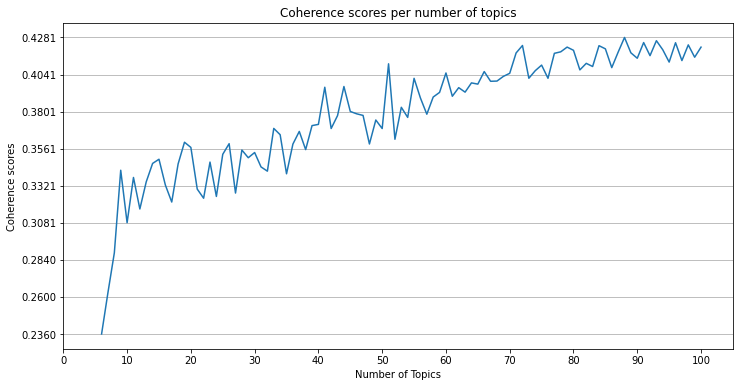

In [108]:

# variables for setup of yticks
score_min = df_coh_scores_opt['coherence_score'].min()
score_max = df_coh_scores_opt['coherence_score'].max()
score_incr = (score_max - score_min) /8

plt.figure(figsize = (12,6))
plt.plot(df_coh_scores_opt['num_topics'], df_coh_scores_opt['coherence_score'], )
plt.xlabel('Number of Topics')
plt.ylabel('Coherence scores')
plt.title('Coherence scores per number of topics')
plt.grid(which = 'major', axis = 'y')
plt.xticks(ticks = np.arange(0,110,10))
plt.yticks(ticks = np.arange(score_min, score_max + score_incr, score_incr))
plt.xlim(0, df_coh_scores_opt['num_topics'].max() *1.05)
plt.show()

We can observe from the plot that, for our dataset, in general in the range chosen, a higher number of topics tend to give a higher coherence score. However we can see that this relationship is not linear.
Let's visualize the topics extracted from the model with the highest score here below.

In [109]:
# selecting the row with max coherence score
df_coh_scores_opt[df_coh_scores_opt['coherence_score'] == df_coh_scores_opt['coherence_score'].max()]

num_topics  coherence_score
82          88         0.428113

In [110]:
# visualizing topic extraction with max coherence score - 88 topics
# note that we select model in row # 82, (since we started fitting from 6 topics, not 1)

tw_lda_gens_88topics = pyLDAvis.gensim.prepare(model_list[82], gens_corpus, id_to_word)
tw_lda_gens_88topics

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
65    -0.137463  0.168436       1        1  2.238302
45     0.106306 -0.044402       2        1  2.066590
68    -0.041927  0.163084       3        1  1.827792
23     0.055659 -0.071595       4        1  1.774218
37     0.028781  0.082080       5        1  1.608647
...         ...       ...     ...      ...       ...
52    -0.120657 -0.060364      84        1  0.741797
27    -0.042032  0.064881      85        1  0.740946
29     0.111108  0.035578      86        1  0.711299
66     0.059573  0.045094      87        1  0.700473
4     -0.008547 -0.006617      88        1  0.632876

[88 rows x 5 columns], topic_info=       Term         Freq        Total Category  logprob  loglift
77   season  1877.000000  1877.000000  Default  30.0000  30.0000
113    know  1137.000000  1137.000000  Default  29.0000  29.0000
7      look   763.000000   763.000000  Default  28.0000  28.0000
43     love  1473.000000  1473.000000  Default  27.0000  27.0000
290    wait   727.000000   727.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
100   movie    17.502375  1621.311646  Topic88  -4.1741   0.5340
282    line     7.958341   121.099503  Topic88  -4.9622   2.3403
170    also    10.906710   412.397400  Topic88  -4.6471   1.4300
128   watch    18.977682  4727.211426  Topic88  -4.0932  -0.4552
62    still    10.102827   593.553650  Topic88  -4.7236   0.9893

[3256 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
1573     53  0.956821            #action
1314     42  0.272885             #actor
1314     53  0.711874             #actor
1332     53  0.971515           #actress
1913     46  0.983056  #alifeonourplanet
...     ...       ...                ...
640      57  0.946152             zombie
1377     80  0.973989               ‘the
903      72  0.987274               “the
993      43  0.832619         ⁦@netflix⁩
993      49  0.151385         ⁦@netflix⁩

[4957 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[66, 46, 69, 24, 38, 27, 37, 12, 45, 63, 86, 78, 9, 29, 20, 17, 8, 88, 23, 39, 40, 87, 81, 71, 2, 77, 21, 62, 55, 14, 84, 72, 61, 32, 79, 59, 85, 11, 3, 19, 73, 58, 43, 36, 13, 48, 56, 47, 35, 18, 57, 82, 26, 70, 15, 7, 41, 74, 10, 76, 31, 80, 1, 54, 52, 60, 33, 44, 68, 49, 75, 4, 34, 65, 6, 51, 42, 64, 83, 16, 22, 25, 50, 53, 28, 30, 67, 5])

In [113]:
pyLDAvis.save_html(tw_lda_gens_88topics,'lda_vis/gensim/lda_gensim_88topics.html')

In the visualization above, we can observe that the topic 'bubbles' are more spread out over the plot area, even though we see some important overlapping in the central area.

If we look at some of the topics, it appears that the terms in each of them are more similar than what we have seen 

If we look at the terms in each topic, it appears now that there is a higher number of them (the terms), that are connected to the topic.
To make an example:

* topic 1 - @netflixturkiye, @acunilicali, #canyaman, #savebayyanliş, #bayyanlış, @ozgecangurel, @acunilicali are all terms connected to the topic *Bay Yanlis*, the turkish series.
* topic 36 - resident, evil, #residentevilinfinitedarkness , infinite, darkness, seem all to be strongly related to *Resident Evil* (there is also the term 2021, which is the year of announced release of the movie)

There are several other examples.
Likely, the fact that, by selecting more topics, we have more relevant words per topic, has contributed to the higher coherence score.

By selecting a higher value for the hyperparameter num_topics (88 in our case), we have therefore 

* a higher number of recognizable topics than what we had with a selected num_topics of 22 and
* more terms (keywords) per each topic.

However, there are obvious downsides.

* Manually seacrching through each of the 88 topics, is a fairly long process and prone to confusion. (We could use the LDA function `.show_topics()` to print a list of the topics instead of looking through the visualization, which might speed up a bit).
* the additional number of **meaningful** topics found, might be very low and not proportional to the additional resources invested in the process.

We have then seen also an example of our analysis with a larger number of topics. We have touched on a high level the pros and cons.
It is recommendable that the decision on which approach to take should be dictated, once again, from our final target.

For example, should we want to know which are the top 10 topics mostly discussed around our brands, going with a lower value of num_topics (than the 'optimal' 88) should work just fine and it would be much faster.

But if instead we'd like to know with precision, which are all the terms/keywords used when tweeting about a topic around our brand, then a higher number of topics would likely work better.

Hence, I would repeat that when trying to optimize the topic extraction from a document, it is important to keep in consideration both the score performance (coherence score) and the interpretability of our results (LDAvis).

It will be interesting to further explore if there are other NLP avenues to explore that would lead to more significant and scalable results.
But overall, I am happy with what I could learn working at this first project.

One very last consideration.

Although not in the scope of this project, I thought of quickly testing if we can achieve a much higher coherence score by selecting a higher number of topics. I selected num_topics = 401 and the coherence score resulted 0.73 (which seems very, very high). Visualizing the results on with LDAvis helped me understand that such score was not representative of how good the topic selection was.
What likely happened, is that by increasing the number of topics that much, a very large chunk of them has been assigned a very low amount of terms, hence highly correlated between each other. This might also explain why every topic from ~ number 60 to the end has been plotted on the same area.

You can check the visualization below.

Thank you again for such a great opportunity to start exploring more in depth the NLP analysis.

I am more than happy to welcome your feedback and recommendation!

In [119]:
%%time

######################################################################
####### calculating coherence score for 400 topics ###################

# calling function to calculate coherence scores

model_400, coherence_values = calculate_multiple_coherence_values(
                                                                    
                                                                    id_to_word, 
                                                                    gens_corpus,
                                                                    df_net['tokens_lemmatized'],
                                                                    400,
                                                                    401,
                                                                    1
                                                                  )

# # # # # # # # # # # # # # # # # # # # # 

Fitting Lda Multicore with 400 topic(s)

calculating coherence score with 400 topic(s)
Coherence score is: 0.7306057154934309

Wall time: 1min 6s


In [120]:
# visualizing topic extraction with max coherence score - 400 topics

tw_lda_gens_400topics = pyLDAvis.gensim.prepare(model_400[0], gens_corpus, id_to_word, mds = 'mmds')
tw_lda_gens_400topics

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
151   -0.062217  0.620753       1        1  8.580782
288   -0.546215  0.273398       2        1  5.665997
332   -0.189738  0.586126       3        1  3.844764
388   -0.569421  0.193789       4        1  3.832789
245   -0.628256 -0.085257       5        1  3.653220
...         ...       ...     ...      ...       ...
255    0.043395 -0.051430     396        1  0.072526
256    0.043395 -0.051430     397        1  0.072526
257    0.043395 -0.051430     398        1  0.072526
258    0.043395 -0.051430     399        1  0.072526
0      0.043395 -0.051430     400        1  0.072526

[400 rows x 5 columns], topic_info=                 Term         Freq        Total  Category  logprob  loglift
128             watch  8400.000000  8400.000000   Default  30.0000  30.0000
77             season  3500.000000  3500.000000   Default  29.0000  29.0000
43               love  2911.000000  2911.000000   Default  28.0000  28.0000
71               show  3916.000000  3916.000000   Default  27.0000  27.0000
146            series  2621.000000  2621.000000   Default  26.0000  26.0000
..                ...          ...          ...       ...      ...      ...
673           disgust     0.065923    22.803328  Topic400  -7.5893   1.3828
674  #robertpattinson     0.065923    22.803328  Topic400  -7.5893   1.3828
675       #tomholland     0.065923    22.803328  Topic400  -7.5893   1.3828
676              rich     0.065923    22.803328  Topic400  -7.5893   1.3828
649          #podcast     0.065923    22.803328  Topic400  -7.5893   1.3828

[23543 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1314      2  0.869072      #actor
609      16  0.792654    #amazing
687       4  0.901990     #amazon
688       4  0.842215      #apple
1719     38  0.805415  #bayyanliş
...     ...       ...         ...
807      14  0.801248      writer
1730     29  0.583335      yanlis
179      39  0.980645        year
472       2  0.078873     youtube
472      13  0.823783     youtube

[430 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[152, 289, 333, 389, 246, 266, 234, 200, 177, 378, 253, 292, 271, 269, 255, 263, 294, 285, 212, 24, 5, 151, 176, 143, 38, 353, 388, 331, 35, 9, 210, 147, 68, 356, 396, 170, 203, 25, 36, 393, 46, 196, 291, 120, 153, 44, 226, 340, 75, 313, 270, 261, 303, 205, 357, 310, 76, 190, 48, 47, 139, 133, 134, 135, 136, 137, 15, 138, 140, 131, 141, 142, 14, 144, 33, 145, 132, 129, 130, 13, 115, 116, 117, 118, 119, 18, 40, 17, 121, 122, 123, 124, 125, 126, 16, 127, 128, 146, 149, 148, 172, 166, 167, 168, 169, 6, 4, 171, 173, 164, 174, 175, 3, 2, 178, 179, 180, 165, 7, 114, 157, 150, 12, 11, 39, 154, 155, 156, 10, 163, 158, 8, 159, 160, 161, 162, 34, 41, 113, 19, 73, 66, 67, 29, 69, 70, 71, 72, 74, 64, 45, 43, 77, 78, 79, 80, 81, 65, 63, 83, 55, 49, 50, 51, 32, 52, 53, 54, 56, 62, 57, 31, 58, 30, 59, 60, 61, 82, 42, 112, 107, 100, 101, 102, 103, 104, 105, 106, 108, 98, 109, 22, 37, 21, 110, 111, 20, 99, 97, 84, 28, 85, 86, 87, 88, 89, 90, 91, 92, 23, 27, 182, 93, 26, 94, 95, 96, 181, 400, 183, 322, 324, 325, 326, 327, 328, 329, 330, 332, 334, 335, 336, 337, 338, 339, 341, 342, 343, 344, 345, 323, 321, 296, 320, 298, 299, 300, 301, 302, 304, 305, 306, 307, 308, 309, 311, 312, 314, 315, 316, 317, 318, 319, 346, 347, 348, 349, 375, 376, 377, 379, 380, 381, 382, 383, 384, 385, 386, 387, 390, 391, 392, 394, 395, 397, 398, 374, 373, 372, 361, 350, 351, 352, 354, 355, 358, 359, 360, 362, 371, 363, 364, 365, 366, 367, 368, 369, 370, 297, 295, 184, 211, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 213, 209, 293, 208, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 197, 198, 199, 399, 201, 202, 204, 206, 207, 235, 236, 237, 238, 267, 268, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282

In [121]:
pyLDAvis.save_html(tw_lda_gens_400topics,'lda_vis/gensim/lda_gensim_400topics.html')